# Modelling - Testing
All trained models will be applied to the test data and performance accuracy compared.

## Load Data

In [11]:
# data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# load data
df = pd.read_csv('data/processed_review_data.csv')

# Train-test split. 20% test. Stratify on y label
X = df.drop(columns = ['classification'])
y = df[['classification']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

X_test['review_text'] = X_test['review_text'].astype(str)

#flatten y
y_test = y_test.values.ravel()
# encode variables (minority class = 1)
y_test = np.where(y_test=='Negative', 1, 0)

## Cleaning

Functions reviously defined in {ref}`references:NLP` are applied to the test data.

In [8]:
# Load functions defined in 'functions.py'
from functions import lower_case,expandContractions,alpha_num,consec_dup,lemma

# Map functions
for func in [lower_case,expandContractions,alpha_num,consec_dup,lemma]:
    X_test['review_text'] = X_test['review_text'].map(func)

## Testing
### Load Trained Models

In [ ]:
# load trained models
import pickle
nb = pickle.load(open("data/nb_trained.sav", 'rb'))
lr = pickle.load(open("data/lr_trained.sav", 'rb'))
svm = pickle.load(open("data/svm_trained.sav", 'rb'))

### Fit Models to Test Data

In [48]:
nb.fit(X_test['review_text'],y_test)
lr.fit(X_test['review_text'],y_test)
svm.fit(X_test['review_text'],y_test)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('svm', SVC(C=1, kernel='linear', random_state=1))])

## Evaluation

### Naive Bayes

F1 Score: 0.9570516540917006


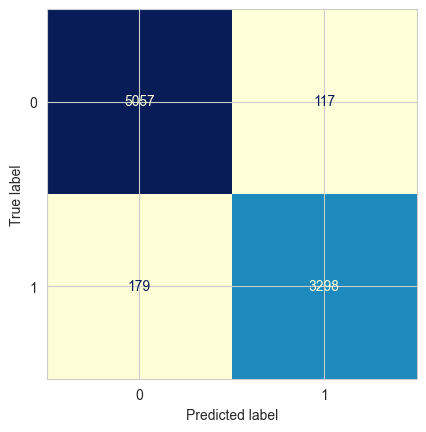

In [171]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

nb_pred = nb.predict(X_test['review_text'])
ConfusionMatrixDisplay.from_estimator(nb, X_test['review_text'], 
                                      y_test, 
                                      colorbar = False,
                                      cmap=plt.cm.YlGnBu)

print(f'F1 Score: {f1_score(y_test, nb_pred)}')

### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5174
           1       0.97      0.96      0.97      3477

    accuracy                           0.97      8651
   macro avg       0.97      0.97      0.97      8651
weighted avg       0.97      0.97      0.97      8651



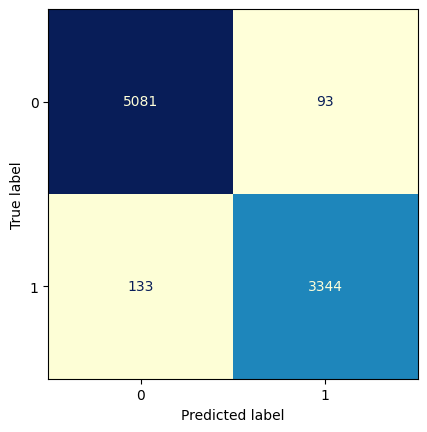

In [77]:
lr_pred = lr.predict(X_test['review_text'])
ConfusionMatrixDisplay.from_estimator(lr, X_test['review_text'], 
                                      y_test, 
                                      colorbar = False,
                                      cmap=plt.cm.YlGnBu)

print(f'F1 Score: {f1_score(y_test, lr_pred)}')

### Support Vector Machine (linear kernel)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5174
           1       0.96      0.95      0.96      3477

    accuracy                           0.96      8651
   macro avg       0.96      0.96      0.96      8651
weighted avg       0.96      0.96      0.96      8651



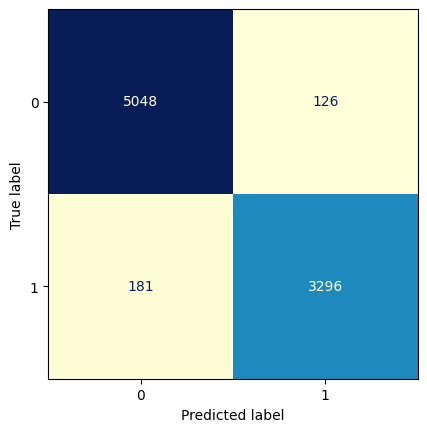

In [76]:
svm_pred = svm.predict(X_test['review_text'])
ConfusionMatrixDisplay.from_estimator(svm, X_test['review_text'], 
                                      y_test, 
                                      colorbar = False,
                                      cmap=plt.cm.YlGnBu)

print(f'F1 Score: {f1_score(y_test, svm_pred)}')

Performance of all models is very good as all demonstrated F1 scores greater than 0.95.

Logistic Regression performed marginally better and so shall be utilised in subsequent interpretation.

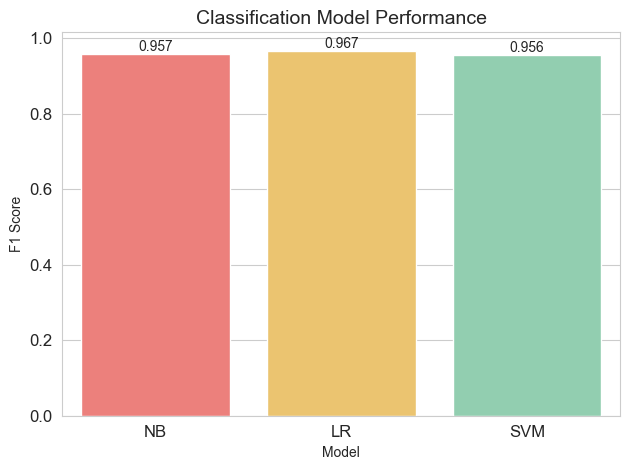

In [170]:
import seaborn as sns

# plot model performance
sns.set_style('whitegrid')
ax = sns.barplot(
    data=pd.DataFrame([['NB', f1_score(y_test, nb_pred)], ['LR', f1_score(y_test, lr_pred)], ['SVM', f1_score(y_test, svm_pred)]],columns=['Model','F1 Score']),
    x="Model",
    y='F1 Score',
    palette=["#FF6F69","#ffcc5c","#88D8B0"])

ax.bar_label(ax.containers[0],fmt='%.3f')
plt.title('Classification Model Performance (Test)',fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

## Interpretation

Lists of tokens and their associated coefficients are extracted from the fitted model.

Part of speech tagging is then applied and the relevant tags stored.

This enables the most relevant nouns for each classification to be extracted by identifying those with extreme negative/positive coefficients.

In [201]:
# Load NLP pipeline
import spacy
spacy.require_cpu()
nlp = spacy.load("en_core_web_sm")

# Extract coefficients from model
coefs = lr.named_steps['lr'].coef_.ravel().tolist()

# Extract word list from model
words = lr.named_steps['vect'].get_feature_names_out().tolist()
words = pd.Series(words)

# POS tagging
def pos(text):
    doc = nlp(text)
    text = [token.pos_ for token in doc]
    text = " ".join(text)
    return text
pos = words.map(pos)

# Store as data frame
df1 = pd.DataFrame({
    'POS': pos,
    'Words': words,
    'Coefs': coefs})


### Negative Classification

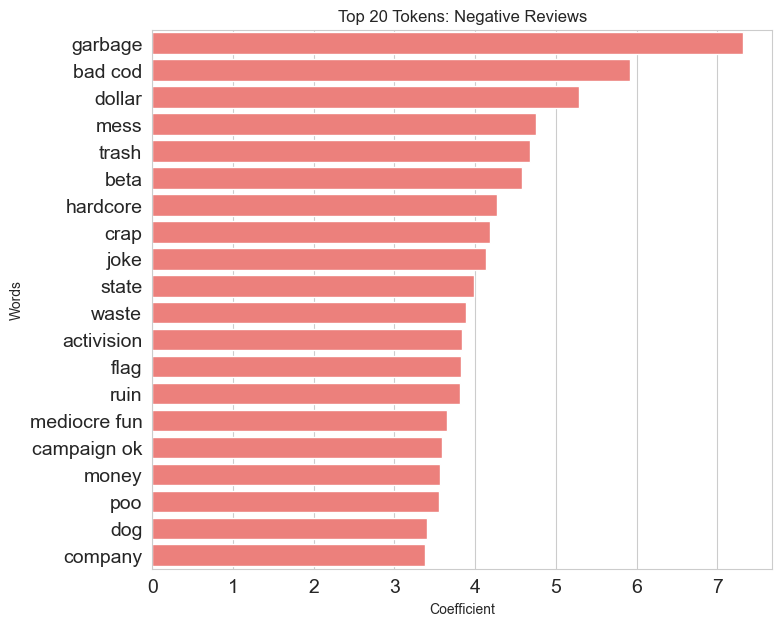

In [228]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,7))
sns.barplot(data = df1[df1['POS'].str.contains("NOUN")].sort_values(by='Coefs',ascending=False,ignore_index=True).head(20),
        y = 'Words',
        x = 'Coefs',
        color="#FF6F69")
        
#ax.invert_yaxis()
ax.tick_params(labelsize=14)
ax.set(title="Top 20 Tokens: Negative Reviews",
       xlabel="Coefficient")

fig.savefig('images/negtokens.png',bbox_inches = "tight");

### Positive Classification

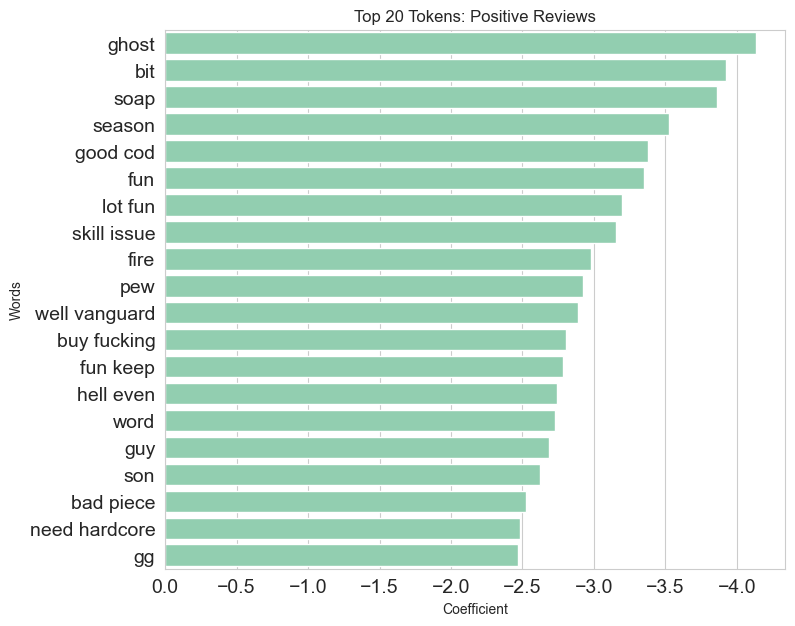

In [229]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,7))
sns.barplot(data = df1[df1['POS'].str.contains("NOUN")].sort_values(by='Coefs',ascending=True,ignore_index=True).head(20),
        y = 'Words',
        x = 'Coefs',
        color="#88D8B0")
        
ax.invert_xaxis()
ax.tick_params(labelsize=14)
ax.set(title="Top 20 Tokens: Positive Reviews",
       xlabel="Coefficient")

fig.savefig('images/postokens.png',bbox_inches = "tight");